In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
oldsysstdout = sys.stdout
class flushfile():
    def __init__(self, f):
        self.f = f
    def __getattr__(self,name): 
        return object.__getattribute__(self.f, name)
    def write(self, x):
        self.f.write(x)
        self.f.flush()
    def flush(self):
        self.f.flush()
sys.stdout = flushfile(sys.stdout)

In [3]:
import json

In [4]:
with open('../train.json', 'r') as f:
    train = json.load(f)
with open('../test.json', 'r') as f:
    test = json.load(f)

In [5]:
vec = []
for i in train:
    [vec.append(j) for j in i['ingredients']]

In [6]:
len(np.unique(vec)), len(vec)

(6714, 428275)

In [7]:
tvec = []
for i in test:
    [tvec.append(j) for j in i['ingredients']]

In [8]:
len(np.unique(tvec)), len(tvec)

(4484, 107395)

In [9]:
len(np.unique(np.concatenate((np.array(vec), np.array(tvec)))))
cats = np.unique((np.array(vec)))

In [10]:
len(train)

39774

In [11]:
train[0]['cuisine']

u'greek'

In [12]:
from scipy.sparse import csr_matrix

In [13]:
X = csr_matrix(map(lambda y: np.array(map(lambda x: 1 if x in y['ingredients'] else 0, cats), dtype='int8'), train))

In [14]:
X.shape

(39774, 6714)

In [15]:
target = map(lambda x: x['cuisine'], train)

In [16]:
b, y = np.unique(target, return_inverse=True)

In [34]:
len(b)

20

In [17]:
test_sp = csr_matrix(map(lambda y: np.array(map(lambda x: 1 if x in y['ingredients'] else 0, cats), dtype='int8'), test))

In [18]:
from sklearn.cross_validation import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

In [19]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score

In [22]:
cross_val_score(LogisticRegression(multi_class='ovr', random_state=0), X, y, scoring = 'accuracy')

array([ 0.774787  ,  0.77366317,  0.77882584])

In [23]:
cross_val_score(LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0), X, y, scoring = 'accuracy')

array([ 0.77184649,  0.77011841,  0.77618473])

In [24]:
parameters = {
    "penalty" : ['l1', 'l2'],
    "C" : [.001, .01, .1, .5, 1., 1.5, 2., 2.5, 3., 5., 10., 100., 1000., 10000.],
    "random_state" : [0],
    "multi_class" : ["ovr"]
}

In [25]:
gs = GridSearchCV(LogisticRegression(), parameters, scoring = 'accuracy', n_jobs=-1, cv = 5)

In [26]:
gs.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'multi_class': ['ovr'], 'C': [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 5.0, 10.0, 100.0, 1000.0, 10000.0], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [27]:
gs.best_score_

0.78113843214160006

In [28]:
gs.best_estimator_

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [66]:
clf = LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [67]:
clf.fit(X, y)
preds = clf.predict(test_sp)

In [78]:
res = pd.DataFrame(columns=['id', 'cuisine'])

res.id = map(lambda x: x['id'], test)

res.cuisine = b[preds]

res.to_csv('./first.csv', index=False)

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
cross_val_score(RandomForestClassifier(random_state=0), X, y, scoring = 'accuracy')

array([ 0.6622182 ,  0.65796817,  0.66133414])

In [31]:
parameters = {
    "n_estimators" : [500],
    "max_features" : ['sqrt', 'log2', None],
    "max_depth" : [2, 5, 8, 12, 20, 50, None],
    "random_state" : [0]
}

In [ ]:
gs = GridSearchCV(RandomForestClassifier(), parameters, scoring = 'accuracy', n_jobs=-1, cv = 5, verbose = 1)

In [ ]:
gs.fit(X, y)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


In [ ]:
gs.best_score_

In [ ]:
gs.best_estimator_

In [99]:
cross_val_score(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False), X, y, scoring = 'accuracy')

array([ 0.72969916,  0.72516781,  0.7258527 ])

In [100]:
from sklearn.svm import SVC

In [102]:
cross_val_score(SVC(kernel='linear',random_state=0), X, y, scoring = 'accuracy')

array([ 0.75065973,  0.74590844,  0.75339571])

In [106]:
cross_val_score(SVC(kernel='poly', degree=2,random_state=0), X, y, scoring = 'accuracy')

array([ 0.19701425,  0.19707369,  0.19710232])

In [107]:
cross_val_score(SVC(kernel='sigmoid',random_state=0), X, y, scoring = 'accuracy')

array([ 0.19701425,  0.19707369,  0.19710232])

In [113]:
parameters = {
    "kernel" : ['linear'],
    "C" : [.01, .1, .5, 1., 2., 5., 10., 100., 1000.],
    "random_state" : [0]
}

In [114]:
gs = GridSearchCV(SVC(), parameters, scoring = 'accuracy', n_jobs=-1, cv = 5, verbose = 1)

In [ ]:
gs.fit(X, y)

In [116]:
cross_val_score(SVC(kernel='linear', C = .1, random_state=0), X, y, scoring = 'accuracy')

array([ 0.75013195,  0.74764311,  0.75166013])

In [117]:
cross_val_score(SVC(kernel='linear', C = 10, random_state=0), X, y, scoring = 'accuracy')

array([ 0.7152228 ,  0.70895241,  0.71687292])

In [19]:
from sklearn.ensemble import AdaBoostClassifier

In [20]:
cross_val_score(AdaBoostClassifier(random_state = 0), X, y, scoring = 'accuracy')

array([ 0.47168816,  0.4819368 ,  0.49071838])

In [21]:
parameters = {
    "n_estimators" : [10, 20, 50, 100, 200, 500],
    "learning_rate" : [.01, .05, .1, .2, .5, .7, 1., 2.],
    "random_state" : [0]
}

In [22]:
gs = GridSearchCV(AdaBoostClassifier(), parameters, scoring = 'accuracy', n_jobs=-1, cv = 5)

In [23]:
gs.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 50, 100, 200, 500], 'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 1.0, 2.0], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [24]:
gs.best_score_

0.55282345250666265

In [20]:
from sklearn.linear_model import Perceptron

In [21]:
cross_val_score(Perceptron(random_state = 0), X, y, scoring = 'accuracy')

array([ 0.71145291,  0.68836262,  0.71664654])

In [23]:
parameters = {
    "penalty" : ['l1', 'l2', 'elasticnet'],
    "alpha" : [0.0001, 0.001, 0.01, 0.1, 1.], 
    "n_iter" : [5, 10, 20, 50],
    "random_state" : [0]
}

In [24]:
gs = GridSearchCV(Perceptron(), parameters, scoring = 'accuracy', n_jobs=-1, cv = 5)

In [25]:
gs.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=5, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2', 'elasticnet'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0], 'random_state': [0], 'n_iter': [5, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [26]:
gs.best_score_

0.61487403831648813

In [27]:
gs.best_estimator_

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty='l2', random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [22]:
from sklearn.ensemble import BaggingClassifier

In [130]:
cross_val_score(BaggingClassifier(base_estimator = LogisticRegression(C=2.0, class_weight=None, 
                                                                      dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), n_estimators = 10, 
                                  max_samples = 0.9, max_features = 0.9, 
                                  n_jobs = -1, random_state = 0), X, y, scoring = 'accuracy')

array([ 0.77621956,  0.77162682,  0.77656203])

In [131]:
clf = BaggingClassifier(base_estimator = LogisticRegression(C=2.0, class_weight=None, 
                                                                      dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), n_estimators = 200, 
                                  max_samples = 0.7, max_features = 0.7, 
                                  n_jobs = -1, random_state = 0)

In [132]:
clf.fit(X, y)
preds = clf.predict(test_sp)

In [133]:
res = pd.DataFrame(columns=['id', 'cuisine'])

res.id = map(lambda x: x['id'], test)

res.cuisine = b[preds]

res.to_csv('./second.csv', index=False)

In [149]:
cross_val_score(BaggingClassifier(base_estimator = Perceptron(alpha=0.0001, class_weight=None, 
                                                              eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty='l2', random_state=0, shuffle=True,
      verbose=0, warm_start=False), n_estimators = 50, 
                                  max_samples = 0.7, max_features = 0.7, 
                                  n_jobs = -1, random_state = 0), X, y, scoring = 'accuracy')

array([ 0.72811581,  0.72878799,  0.73038032])

In [150]:
clf = BaggingClassifier(base_estimator = Perceptron(random_state = 0), n_estimators = 1500, 
                                  max_samples = 0.7, max_features = 0.7, 
                                  n_jobs = -1, random_state = 0)

In [151]:
clf.fit(X, y)
preds = clf.predict(test_sp)

In [152]:
res = pd.DataFrame(columns=['id', 'cuisine'])

res.id = map(lambda x: x['id'], test)

res.cuisine = b[preds]

res.to_csv('./fourth.csv', index=False)

In [30]:
import lasagne
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer
from lasagne.utils import floatX

Using gpu device 0: GeForce GTX 670 (CNMeM is disabled)


In [31]:
import theano.tensor as T

In [33]:
input_var = T.tensor3('inputs')
target_var = T.ivector('targets')

In [144]:
net = {}
net['input'] = InputLayer((None, 1, 6714),input_var=input_var)
net['fc1'] = DenseLayer(net['input'], num_units=4000,
                        nonlinearity = lasagne.nonlinearities.rectify,
                        W = lasagne.init.GlorotUniform(gain = 'relu'))
net['drop1'] = DropoutLayer(net['fc1'], p=0.5)
net['fc2'] = DenseLayer(net['drop1'], num_units=2000,
                        nonlinearity = lasagne.nonlinearities.rectify,
                        W = lasagne.init.GlorotUniform(gain = 'relu'))
net['drop2'] = DropoutLayer(net['fc2'], p=0.5)
net['fc3'] = DenseLayer(net['drop2'], num_units=700,
                        nonlinearity = lasagne.nonlinearities.rectify,
                        W = lasagne.init.GlorotUniform(gain = 'relu'))
net['drop3'] = DropoutLayer(net['fc3'], p=0.5)
net['fc4'] = DenseLayer(net['drop3'], num_units=200,
                        nonlinearity = lasagne.nonlinearities.rectify,
                        W = lasagne.init.GlorotUniform(gain = 'relu'))
net['drop4'] = DropoutLayer(net['fc4'], p=0.5)
net['fc5'] = DenseLayer(net['drop4'], num_units=20, nonlinearity=lasagne.nonlinearities.softmax)
output_layer = net['fc5']

In [101]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt].reshape((-1, 1, 6714)), targets[excerpt]

In [102]:
import theano

In [145]:
prediction = lasagne.layers.get_output(output_layer)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()
# We could add some weight decay as well here, see lasagne.regularization.

# Create update expressions for training, i.e., how to modify the
# parameters at each training step. Here, we'll use Stochastic Gradient
# Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
params = lasagne.layers.get_all_params(output_layer, trainable=True)
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.05, momentum=0.9)

# Create a loss expression for validation/testing. The crucial difference
# here is that we do a deterministic forward pass through the network,
# disabling dropout layers.
test_prediction = lasagne.layers.get_output(output_layer, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
# As a bonus, also create an expression for the classification accuracy:
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)


# Compile a function performing a training step on a mini-batch (by giving
# the updates dictionary) and returning the corresponding training loss:
train_fn = theano.function([input_var, target_var], loss, updates=updates)

# Compile a second function computing the validation loss and accuracy:
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

test_fn = theano.function([input_var], test_prediction)

In [107]:
import time

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

In [77]:
X_train = X_train.toarray()

In [78]:
X_test = X_test.toarray()

In [90]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

In [146]:
num_epochs = 1000
batchsize = 2531

terr = []
tacc = []
verr = []
vacc = []
eps = []

# Finally, launch the training loop.
print("Starting training...")
# We iterate over epochs:
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batchsize, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        err, acc = val_fn(inputs, targets)
        train_acc += acc
        train_batches += 1

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 1, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  training accuracy:\t\t{:.6f}".format(
        train_acc / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.6f}".format(
        val_acc / val_batches))
    
    eps.append(epoch+1)
    terr.append(train_err / float(train_batches))
    tacc.append(train_acc / float(train_batches))
    verr.append(val_err / float(val_batches))
    vacc.append(val_acc / float(val_batches))

Starting training...
Epoch 1 of 1000 took 65.795s
  training loss:		2.809350
  training accuracy:		0.208901
  validation loss:		2.603158
  validation accuracy:		0.250482
Epoch 2 of 1000 took 65.356s
  training loss:		2.605895
  training accuracy:		0.294601
  validation loss:		2.565747
  validation accuracy:		0.285343
Epoch 3 of 1000 took 65.350s
  training loss:		2.511924
  training accuracy:		0.323156
  validation loss:		2.385382
  validation accuracy:		0.343250
Epoch 4 of 1000 took 65.590s
  training loss:		2.354345
  training accuracy:		0.396214
  validation loss:		2.105948
  validation accuracy:		0.432079
Epoch 5 of 1000 took 65.351s
  training loss:		2.128641
  training accuracy:		0.470026
  validation loss:		1.871118
  validation accuracy:		0.479259
Epoch 6 of 1000 took 65.311s
  training loss:		1.943014
  training accuracy:		0.501203
  validation loss:		1.713582
  validation accuracy:		0.505740
Epoch 7 of 1000 took 65.383s
  training loss:		1.815612
  training accuracy:		0.52372

KeyboardInterrupt: 

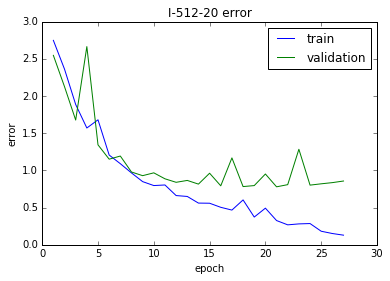

In [141]:
plt.title('I-512-20 error')
plt.xlabel('epoch')
plt.ylabel('error')
plt.plot(eps, terr, label = 'train')
plt.plot(eps, verr, label = 'validation')
plt.legend(loc = 0)

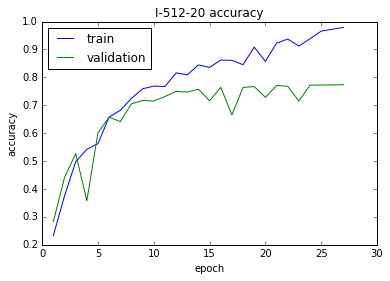

In [142]:
plt.title('I-512-20 accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(eps, tacc, label = 'train')
plt.plot(eps, vacc, label = 'validation')
plt.legend(loc = 0)

In [125]:
eps_f = np.array(eps)
terr_f = np.array(terr)
verr_f = np.array(verr)
tacc_f = np.array(tacc)
vacc_f = np.array(vacc)

In [143]:
eps_s = np.array(eps)
terr_s = np.array(terr)
verr_s = np.array(verr)
tacc_s = np.array(tacc)
vacc_s = np.array(vacc)